In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [4]:
# ============================================================================
# STEP 1: LOAD ALL DATA
# ============================================================================

print("\nSTEP 1: Loading Data...")

# Load historical emissions (with sectors)
emissions_raw = pd.read_csv("Datasets/historical_emissions.csv")
print(f"   Emissions data: {emissions_raw.shape}")

# Load predictions (to identify top 10 countries by 2030)
predictions_total = pd.read_csv('emissions_predictions_2021_2030.csv')
print(f"   Predictions data: {predictions_total.shape}")

# Load GDP and Population data
gdp_pop = pd.read_csv('gdp_population_predicted_2024.csv')
print(f"   GDP/Population data: {gdp_pop.shape}")

# Year columns from emissions data
year_cols = [col for col in emissions_raw.columns if col.isdigit()]
latest_year = max(year_cols)
print(f"   Years available: {min(year_cols)} - {latest_year}")


STEP 1: Loading Data...
   Emissions data: (11058, 37)
   Predictions data: (1530, 6)
   GDP/Population data: (6804, 11)
   Years available: 1990 - 2020


In [5]:
# ============================================================================
# STEP 2: IDENTIFY TOP 10 COUNTRIES BY 2030 PREDICTIONS
# ============================================================================

print("\nSTEP 2: Identifying Top 10 Countries by 2030...")

top10_2030 = predictions_total[predictions_total['Year'] == 2030].nlargest(10, 'Predicted_Emissions')

TOP10_COUNTRIES = top10_2030['ISO'].tolist()

print(f"\n{'Rank':<5} {'Country':<25} {'Predicted 2030 Emissions':>25}")
print("-"*60)
for rank, (_, row) in enumerate(top10_2030.iterrows(), 1):
    print(f"{rank:<5} {row['Country']:<25} {row['Predicted_Emissions']:>22,.2f}")


STEP 2: Identifying Top 10 Countries by 2030...

Rank  Country                    Predicted 2030 Emissions
------------------------------------------------------------
1     China                                  14,910.26
2     India                                   5,264.27
3     United States                           4,227.59
4     Russia                                  2,108.45
5     Indonesia                               1,972.37
6     Brazil                                  1,738.57
7     Iran                                    1,046.53
8     Democratic Republic of the Congo                 929.47
9     Japan                                     803.71
10    Pakistan                                  784.98


In [6]:
# ============================================================================
# STEP 3: DEFINE MAIN SECTORS (from EDA)
# ============================================================================

print("\nSTEP 3: Defining Main Sectors...")

# Main sectors (excluding totals and sub-sectors to avoid double counting)
MAIN_SECTORS = [
    'Energy',
    'Industrial Processes',
    'Agriculture',
    'Waste',
    'Land-Use Change and Forestry'
]

print(f"   Sectors to predict: {MAIN_SECTORS}")


STEP 3: Defining Main Sectors...
   Sectors to predict: ['Energy', 'Industrial Processes', 'Agriculture', 'Waste', 'Land-Use Change and Forestry']


In [7]:
# ============================================================================
# STEP 4: EXTRACT SECTOR DATA (ALL COUNTRIES)
# ============================================================================

print("\nSTEP 4: Extracting Sector Data...")

# Filter for All GHG and main sectors
sector_data = emissions_raw[
    (emissions_raw['Gas'] == 'All GHG') &
    (emissions_raw['Sector'].isin(MAIN_SECTORS))
].copy()

print(f"   Filtered sector data shape: {sector_data.shape}")
print(f"   Countries: {sector_data['Country'].nunique()}")

# Reshape to long format
sector_long = sector_data.melt(
    id_vars=['ISO', 'Country', 'Sector'],
    value_vars=year_cols,
    var_name='Year',
    value_name='Emissions'
)

sector_long['Year'] = sector_long['Year'].astype(int)
sector_long = sector_long.sort_values(['ISO', 'Sector', 'Year']).reset_index(drop=True)

print(f"   Long format shape: {sector_long.shape}")


STEP 4: Extracting Sector Data...
   Filtered sector data shape: (970, 37)
   Countries: 194
   Long format shape: (30070, 5)


In [8]:
# ============================================================================
# STEP 5: MERGE WITH GDP AND POPULATION
# ============================================================================

print("\nSTEP 5: Merging with GDP/Population Data...")

# Prepare GDP/Pop data
gdp_pop_subset = gdp_pop[['Country Code', 'Year', 'GDP', 'Population', 
                           'GDP_growth_1yr', 'Population_growth_1yr', 'GDP_per_capita']].copy()

# Merge
sector_merged = sector_long.merge(
    gdp_pop_subset,
    left_on=['ISO', 'Year'],
    right_on=['Country Code', 'Year'],
    how='left'
)

sector_merged = sector_merged.drop(columns=['Country Code'])

print(f"   Merged shape: {sector_merged.shape}")
print(f"   Columns: {sector_merged.columns.tolist()}")

# Check for missing GDP data
missing_gdp = sector_merged['GDP'].isna().sum()
print(f"   Rows with missing GDP: {missing_gdp}")


STEP 5: Merging with GDP/Population Data...
   Merged shape: (30070, 10)
   Columns: ['ISO', 'Country', 'Sector', 'Year', 'Emissions', 'GDP', 'Population', 'GDP_growth_1yr', 'Population_growth_1yr', 'GDP_per_capita']
   Rows with missing GDP: 6200


In [9]:
sector_merged.to_csv('sector_emissions_gdp_population.csv', index=False)

In [10]:
# ============================================================================
# STEP 6: FEATURE ENGINEERING (FIXED - No Data Leakage)
# ============================================================================

print("\nSTEP 6: Creating Features (Fixed)...")

def create_features(df):
    """Create lag and derived features for sector emissions - NO LEAKAGE"""
    df = df.sort_values(['ISO', 'Sector', 'Year']).reset_index(drop=True)
    
    # Emission lag features (SAFE - uses past values only)
    for lag in [1, 2, 3]:
        df[f'Emissions_lag_{lag}'] = df.groupby(['ISO', 'Sector'])['Emissions'].shift(lag)
    
    # Emission growth rate (SAFE - based on lagged values)
    df['Emissions_growth'] = (df['Emissions_lag_1'] - df['Emissions_lag_2']) / df['Emissions_lag_2']
    
    # Rolling average of PAST 3 years (FIXED - excludes current year)
    df['Emissions_rolling_3yr'] = (df['Emissions_lag_1'] + df['Emissions_lag_2'] + df['Emissions_lag_3']) / 3
    
    # Emissions per capita using LAGGED emissions (FIXED)
    df['Emissions_per_capita'] = df['Emissions_lag_1'] / df['Population']
    
    # Emissions intensity using LAGGED emissions (FIXED)
    df['Emissions_intensity'] = df['Emissions_lag_1'] / df['GDP']
    
    return df

sector_features = create_features(sector_merged.copy())

# Fill NaN in growth columns
sector_features['Emissions_growth'] = sector_features['Emissions_growth'].fillna(0)
sector_features['GDP_growth_1yr'] = sector_features['GDP_growth_1yr'].fillna(0)
sector_features['Population_growth_1yr'] = sector_features['Population_growth_1yr'].fillna(0)

# Drop rows with NaN in lag features
sector_features = sector_features.dropna(subset=['Emissions_lag_1', 'Emissions_lag_2', 'Emissions_lag_3', 'GDP', 'Population'])

# Handle infinities
sector_features = sector_features.replace([np.inf, -np.inf], 0)

print(f"   Final features shape: {sector_features.shape}")


STEP 6: Creating Features (Fixed)...
   Final features shape: (21553, 17)


In [11]:
sector_features.to_csv('sector_emissions_gdp_population_features.csv', index=False)

In [12]:
# ============================================================================
# STEP 7: DEFINE FEATURE COLUMNS
# ============================================================================

print("\nSTEP 7: Defining Feature Columns...")

feature_cols = [
    # Emission-based features
    'Emissions_lag_1', 'Emissions_lag_2', 'Emissions_lag_3',
    'Emissions_growth', 'Emissions_rolling_3yr',
    # Economic features
    'GDP', 'GDP_growth_1yr', 'GDP_per_capita',
    # Population features
    'Population', 'Population_growth_1yr',
    # Derived features
    'Emissions_per_capita', 'Emissions_intensity'
]

target = 'Emissions'

print(f"   Features ({len(feature_cols)}): {feature_cols}")


STEP 7: Defining Feature Columns...
   Features (12): ['Emissions_lag_1', 'Emissions_lag_2', 'Emissions_lag_3', 'Emissions_growth', 'Emissions_rolling_3yr', 'GDP', 'GDP_growth_1yr', 'GDP_per_capita', 'Population', 'Population_growth_1yr', 'Emissions_per_capita', 'Emissions_intensity']


In [13]:
# ============================================================================
# STEP 8: TRAIN MODELS FOR EACH SECTOR WITH TimeSeriesSplit CV
# ============================================================================

print("\n" + "="*70)
print("STEP 8: TRAINING MODELS WITH TimeSeriesSplit (One Per Sector)")
print("="*70)

N_SPLITS = 5  # Number of CV folds

sector_models = {}
sector_scalers = {}
sector_results = {}

# Define models
models_dict = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'SVR': SVR(kernel='rbf', C=1.0)
}

for sector in MAIN_SECTORS:
    print(f"\n{'─'*60}")
    print(f"Training Model for: {sector}")
    print(f"{'─'*60}")
    
    # Filter data for this sector and sort by year
    sector_df = sector_features[sector_features['Sector'] == sector].copy()
    sector_df = sector_df.sort_values('Year').reset_index(drop=True)
    
    if len(sector_df) < 50:
        print(f"   Insufficient data ({len(sector_df)} rows). Skipping...")
        continue
    
    # Prepare X and y
    X = sector_df[feature_cols].values
    y = sector_df[target].values
    
    print(f"   Total samples: {len(X)}")
    
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    
    # Show fold structure
    print(f"   TimeSeriesSplit: {N_SPLITS} folds")
    
    # Track results for each model
    model_cv_results = {}
    
    for model_name, model_template in models_dict.items():
        fold_scores = {'R2': [], 'MAE': []}
        
        for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
            # Split data
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Clone model for each fold
            model = clone(model_template)
            
            # Train
            model.fit(X_train_scaled, y_train)
            
            # Predict
            y_pred = model.predict(X_test_scaled)
            
            # Evaluate
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            
            fold_scores['R2'].append(r2)
            fold_scores['MAE'].append(mae)
        
        # Store mean results
        model_cv_results[model_name] = {
            'R2_mean': np.mean(fold_scores['R2']),
            'R2_std': np.std(fold_scores['R2']),
            'MAE_mean': np.mean(fold_scores['MAE']),
            'MAE_std': np.std(fold_scores['MAE']),
            'fold_scores': fold_scores
        }
    
    # Find best model by CV R² mean
    best_model_name = max(model_cv_results, key=lambda x: model_cv_results[x]['R2_mean'])
    best_cv_results = model_cv_results[best_model_name]
    
    # Train final model on full data for predictions
    scaler_final = StandardScaler()
    X_scaled_full = scaler_final.fit_transform(X)
    
    final_model = clone(models_dict[best_model_name])
    final_model.fit(X_scaled_full, y)
    
    # Overfitting check: Train score vs CV score
    y_train_pred = final_model.predict(X_scaled_full)
    train_r2 = r2_score(y, y_train_pred)
    r2_gap = train_r2 - best_cv_results['R2_mean']
    
    # Store results
    sector_models[sector] = final_model
    sector_scalers[sector] = scaler_final
    sector_results[sector] = {
        'model_name': best_model_name,
        'cv_r2_mean': best_cv_results['R2_mean'],
        'cv_r2_std': best_cv_results['R2_std'],
        'cv_mae_mean': best_cv_results['MAE_mean'],
        'cv_mae_std': best_cv_results['MAE_std'],
        'train_r2': train_r2,
        'r2_gap': r2_gap,
        'train_size': len(X),
        'all_models_cv': model_cv_results
    }
    
    # Overfitting status
    if r2_gap > 0.05:
        status = "🔴 OVERFITTING"
    elif r2_gap > 0.02:
        status = "🟡 SLIGHT"
    else:
        status = "🟢 GOOD FIT"
    
    print(f"   ✅ Best Model: {best_model_name}")
    print(f"   📊 CV R²: {best_cv_results['R2_mean']:.4f} (±{best_cv_results['R2_std']:.4f})")
    print(f"   📊 CV MAE: {best_cv_results['MAE_mean']:,.2f} (±{best_cv_results['MAE_std']:,.2f})")
    print(f"   📊 Train R²: {train_r2:.4f} | Gap: {r2_gap:+.4f} {status}")


STEP 8: TRAINING MODELS WITH TimeSeriesSplit (One Per Sector)

────────────────────────────────────────────────────────────
Training Model for: Energy
────────────────────────────────────────────────────────────
   Total samples: 4311
   TimeSeriesSplit: 5 folds
   ✅ Best Model: Linear Regression
   📊 CV R²: 0.9985 (±0.0003)
   📊 CV MAE: 7.30 (±1.79)
   📊 Train R²: 0.9989 | Gap: +0.0004 🟢 GOOD FIT

────────────────────────────────────────────────────────────
Training Model for: Industrial Processes
────────────────────────────────────────────────────────────
   Total samples: 4312
   TimeSeriesSplit: 5 folds
   ✅ Best Model: Linear Regression
   📊 CV R²: 0.9969 (±0.0017)
   📊 CV MAE: 0.72 (±0.11)
   📊 Train R²: 0.9983 | Gap: +0.0014 🟢 GOOD FIT

────────────────────────────────────────────────────────────
Training Model for: Agriculture
────────────────────────────────────────────────────────────
   Total samples: 4309
   TimeSeriesSplit: 5 folds
   ✅ Best Model: Lasso Regression
   📊 


MODEL PERFORMANCE SUMMARY (TimeSeriesSplit CV)

Sector                              Model                 CV R²     ±Std  Train R²      Gap Status      
---------------------------------------------------------------------------------------------------------
Energy                              Linear Regression    0.9985   0.0003    0.9989  +0.0004 🟢 GOOD      
Industrial Processes                Linear Regression    0.9969   0.0017    0.9983  +0.0014 🟢 GOOD      
Agriculture                         Lasso Regression     0.9979   0.0010    0.9981  +0.0002 🟢 GOOD      
Waste                               Linear Regression    0.9993   0.0004    0.9994  +0.0001 🟢 GOOD      
Land-Use Change and Forestry        Random Forest        0.9178   0.0237    0.9901  +0.0723 🔴 OVERFIT   


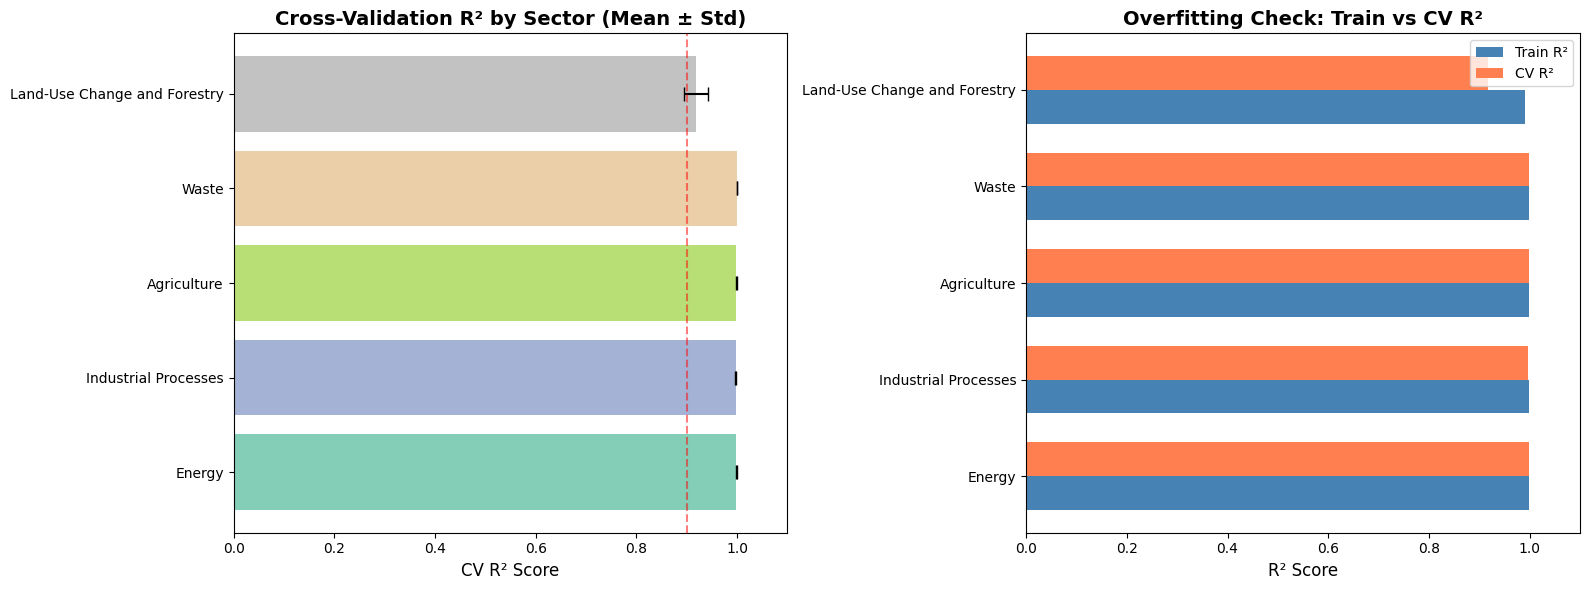


MODEL SELECTION DETAILS BY SECTOR

📌 Energy:
   Model                     CV R²       ±Std
   ------------------------------------------
   ⭐ Linear Regression      0.9985     0.0003
      Lasso Regression       0.9981     0.0012
      Ridge Regression       0.9979     0.0014
      Decision Tree          0.9830     0.0157
      ElasticNet             0.9808     0.0093

📌 Industrial Processes:
   Model                     CV R²       ±Std
   ------------------------------------------
   ⭐ Linear Regression      0.9969     0.0017
      Ridge Regression       0.9967     0.0018
      Lasso Regression       0.9954     0.0038
      ElasticNet             0.9716     0.0191
      Gradient Boosting      0.9337     0.0302

📌 Agriculture:
   Model                     CV R²       ±Std
   ------------------------------------------
   ⭐ Lasso Regression       0.9979     0.0010
      Ridge Regression       0.9978     0.0011
      Linear Regression      0.9977     0.0012
      Random Forest          

In [14]:
# ============================================================================
# STEP 9: MODEL SUMMARY WITH OVERFITTING ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("MODEL PERFORMANCE SUMMARY (TimeSeriesSplit CV)")
print("="*70)

print(f"\n{'Sector':<35} {'Model':<18} {'CV R²':>8} {'±Std':>8} {'Train R²':>9} {'Gap':>8} {'Status':<12}")
print("-"*105)
for sector, result in sector_results.items():
    gap = result['r2_gap']
    if gap > 0.05:
        status = "🔴 OVERFIT"
    elif gap > 0.02:
        status = "🟡 SLIGHT"
    else:
        status = "🟢 GOOD"
    
    print(f"{sector:<35} {result['model_name']:<18} {result['cv_r2_mean']:>8.4f} {result['cv_r2_std']:>8.4f} "
          f"{result['train_r2']:>9.4f} {result['r2_gap']:>+8.4f} {status:<12}")

# Visualization: CV Performance with Error Bars
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. CV R² by Sector
ax1 = axes[0]
sectors = list(sector_results.keys())
r2_means = [sector_results[s]['cv_r2_mean'] for s in sectors]
r2_stds = [sector_results[s]['cv_r2_std'] for s in sectors]

colors = plt.cm.Set2(np.linspace(0, 1, len(sectors)))
bars = ax1.barh(sectors, r2_means, xerr=r2_stds, color=colors, capsize=5, alpha=0.8)
ax1.set_xlabel('CV R² Score', fontsize=12)
ax1.set_title('Cross-Validation R² by Sector (Mean ± Std)', fontsize=14, fontweight='bold')
ax1.axvline(x=0.9, color='red', linestyle='--', alpha=0.5)
ax1.set_xlim([0, 1.1])

# 2. Overfitting Check (Train vs CV)
ax2 = axes[1]
train_r2s = [sector_results[s]['train_r2'] for s in sectors]
cv_r2s = [sector_results[s]['cv_r2_mean'] for s in sectors]

x = np.arange(len(sectors))
width = 0.35

bars1 = ax2.barh(x - width/2, train_r2s, width, label='Train R²', color='steelblue')
bars2 = ax2.barh(x + width/2, cv_r2s, width, label='CV R²', color='coral')

ax2.set_yticks(x)
ax2.set_yticklabels(sectors)
ax2.set_xlabel('R² Score', fontsize=12)
ax2.set_title('Overfitting Check: Train vs CV R²', fontsize=14, fontweight='bold')
ax2.legend()
ax2.set_xlim([0, 1.1])

plt.tight_layout()
plt.savefig('sector_timeseries_cv_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Model comparison across sectors
print("\n" + "="*70)
print("MODEL SELECTION DETAILS BY SECTOR")
print("="*70)

for sector in MAIN_SECTORS:
    if sector not in sector_results:
        continue
    
    print(f"\n📌 {sector}:")
    all_models = sector_results[sector]['all_models_cv']
    
    # Sort by CV R²
    sorted_models = sorted(all_models.items(), key=lambda x: x[1]['R2_mean'], reverse=True)
    
    print(f"   {'Model':<20} {'CV R²':>10} {'±Std':>10}")
    print(f"   {'-'*42}")
    for model_name, scores in sorted_models[:5]:  # Top 5 only
        marker = "⭐" if model_name == sector_results[sector]['model_name'] else "  "
        print(f"   {marker} {model_name:<18} {scores['R2_mean']:>10.4f} {scores['R2_std']:>10.4f}")

In [15]:
# ============================================================================
# STEP 10: GENERATE PREDICTIONS FOR TOP 10 COUNTRIES (2021-2030)
# ============================================================================

print("\n" + "="*70)
print("STEP 10: GENERATING PREDICTIONS (2021-2030)")
print("="*70)

all_predictions = []

for sector in MAIN_SECTORS:
    if sector not in sector_models:
        continue
    
    print(f"\nPredicting: {sector}")
    
    model = sector_models[sector]
    scaler = sector_scalers[sector]
    
    sector_df = sector_features[sector_features['Sector'] == sector].copy()
    
    for country_iso in TOP10_COUNTRIES:
        country_data = sector_df[sector_df['ISO'] == country_iso].sort_values('Year')
        
        if country_data.empty:
            continue
        
        country_name = country_data['Country'].iloc[0]
        last_row = country_data.iloc[-1].copy()
        last_year_data = int(last_row['Year'])
        
        # Get GDP/Pop projections for this country
        country_gdp = gdp_pop[gdp_pop['Country Code'] == country_iso].sort_values('Year')
        
        for year in range(max(last_year_data + 1, 2021), 2031):
            # Get GDP and Population for this year (from predictions or extrapolate)
            gdp_row = country_gdp[country_gdp['Year'] == year]
            
            if not gdp_row.empty:
                new_gdp = gdp_row['GDP'].values[0]
                new_pop = gdp_row['Population'].values[0]
                gdp_growth = gdp_row['GDP_growth_1yr'].values[0] if 'GDP_growth_1yr' in gdp_row.columns else 0.025
                pop_growth = gdp_row['Population_growth_1yr'].values[0] if 'Population_growth_1yr' in gdp_row.columns else 0.01
            else:
                # Extrapolate with assumed growth rates
                gdp_growth = 0.025
                pop_growth = 0.01
                new_gdp = last_row['GDP'] * (1 + gdp_growth)
                new_pop = last_row['Population'] * (1 + pop_growth)
            
            # Prepare features
            features = {
                'Emissions_lag_1': last_row['Emissions'],
                'Emissions_lag_2': last_row['Emissions_lag_1'],
                'Emissions_lag_3': last_row['Emissions_lag_2'],
                'Emissions_growth': last_row['Emissions_growth'],
                'Emissions_rolling_3yr': (last_row['Emissions'] + last_row['Emissions_lag_1'] + last_row['Emissions_lag_2']) / 3,
                'GDP': new_gdp,
                'GDP_growth_1yr': gdp_growth if isinstance(gdp_growth, float) else 0.025,
                'GDP_per_capita': new_gdp / new_pop if new_pop > 0 else 0,
                'Population': new_pop,
                'Population_growth_1yr': pop_growth if isinstance(pop_growth, float) else 0.01,
                'Emissions_per_capita': last_row['Emissions'] / new_pop if new_pop > 0 else 0,
                'Emissions_intensity': last_row['Emissions'] / new_gdp if new_gdp > 0 else 0
            }
            
            # Create feature array
            X_pred = np.array([[features[f] for f in feature_cols]])
            X_pred_scaled = scaler.transform(X_pred)
            
            # Predict
            pred_emissions = model.predict(X_pred_scaled)[0]
            pred_emissions = max(0, pred_emissions)  # Ensure non-negative
            
            # Store prediction
            all_predictions.append({
                'ISO': country_iso,
                'Country': country_name,
                'Sector': sector,
                'Year': year,
                'Predicted_Emissions': pred_emissions
            })
            
            # Update last_row for next iteration
            last_row['Emissions_lag_3'] = last_row['Emissions_lag_2']
            last_row['Emissions_lag_2'] = last_row['Emissions_lag_1']
            last_row['Emissions_lag_1'] = last_row['Emissions']
            last_row['Emissions'] = pred_emissions
            last_row['Emissions_growth'] = (pred_emissions - last_row['Emissions_lag_2']) / last_row['Emissions_lag_2'] if last_row['Emissions_lag_2'] > 0 else 0
            last_row['GDP'] = new_gdp
            last_row['Population'] = new_pop
            last_row['Year'] = year

# Create predictions DataFrame
predictions_df = pd.DataFrame(all_predictions)

print(f"\nGenerated {len(predictions_df)} predictions")
print(f"   Countries: {predictions_df['ISO'].nunique()}")
print(f"   Sectors: {predictions_df['Sector'].nunique()}")
print(f"   Years: {predictions_df['Year'].min()} - {predictions_df['Year'].max()}")



STEP 10: GENERATING PREDICTIONS (2021-2030)

Predicting: Energy

Predicting: Industrial Processes

Predicting: Agriculture

Predicting: Waste

Predicting: Land-Use Change and Forestry

Generated 500 predictions
   Countries: 10
   Sectors: 5
   Years: 2021 - 2030


In [16]:
# ============================================================================
# STEP 11: SAVE PREDICTIONS TO CSV
# ============================================================================

print("\nSTEP 11: Saving Predictions...")

predictions_df.to_csv('sector_emissions_predictions_2021_2030.csv', index=False)
print("   Saved to: sector_emissions_predictions_2021_2030.csv")


STEP 11: Saving Predictions...
   Saved to: sector_emissions_predictions_2021_2030.csv



STEP 12: Creating Visualizations...


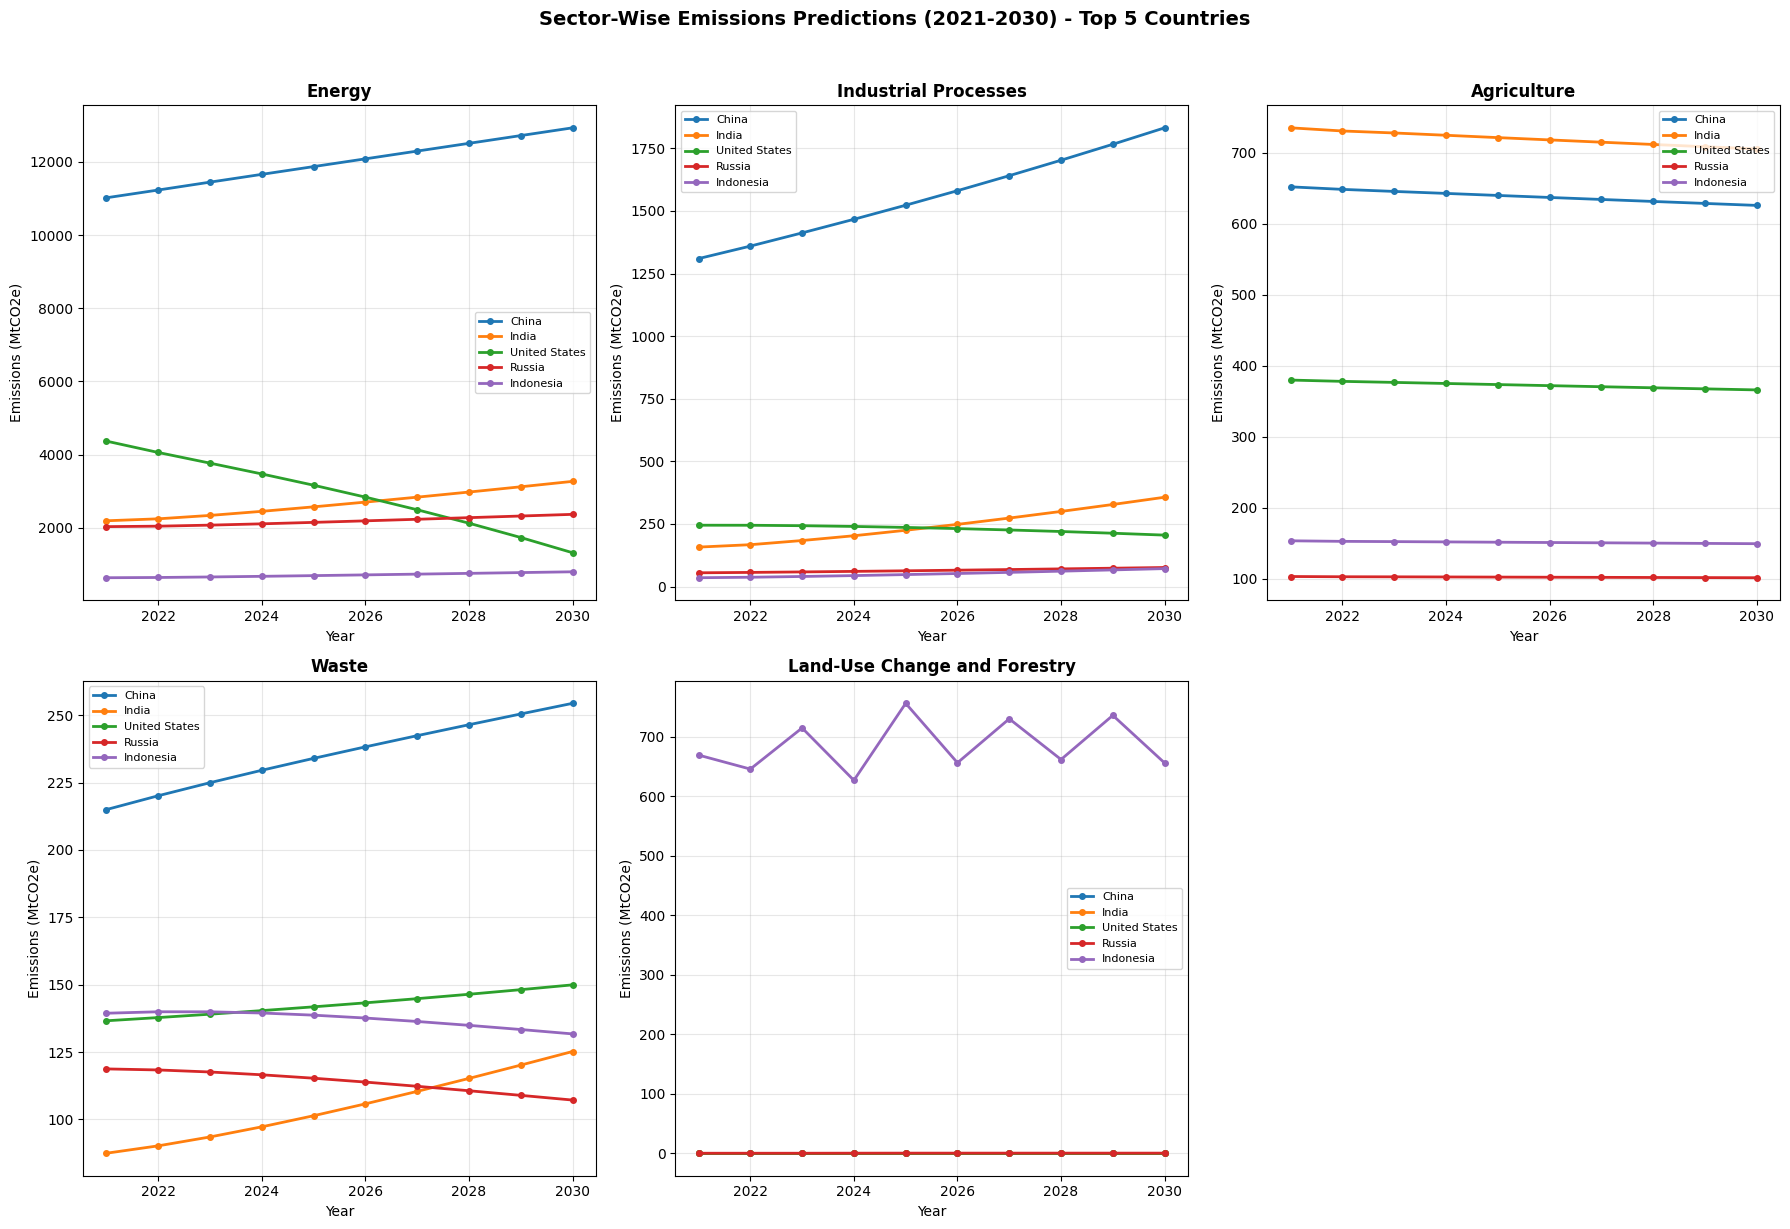

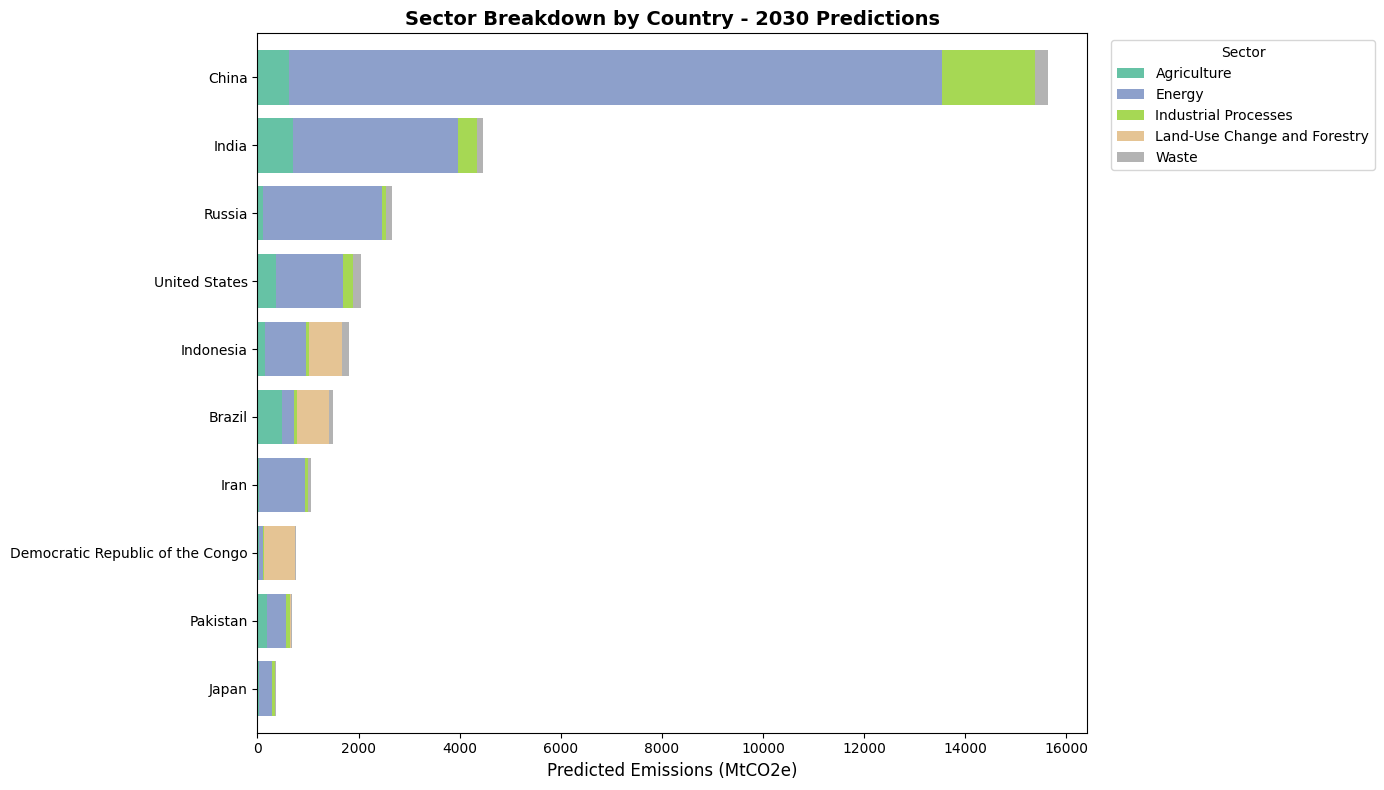

KeyError: 'r2'

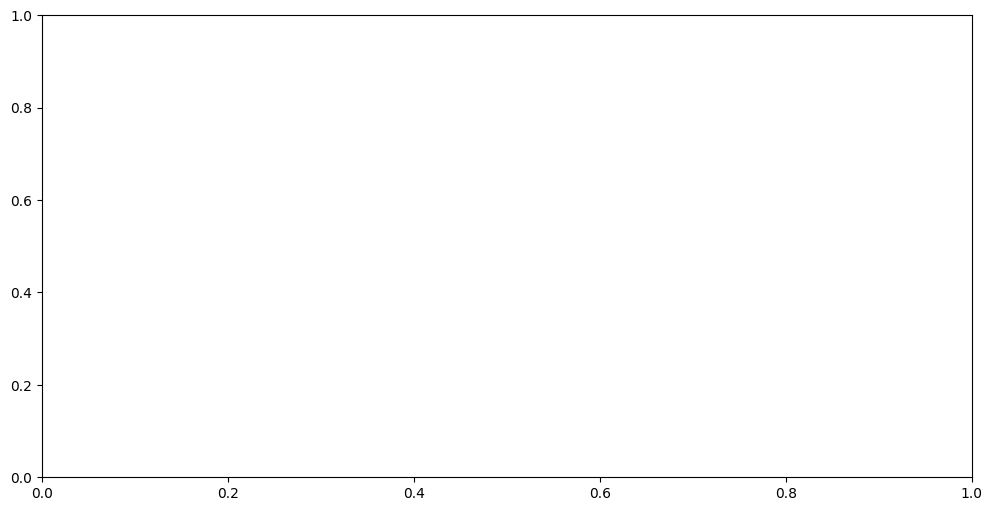

In [17]:
# ============================================================================
# STEP 12: VISUALIZATIONS
# ============================================================================

print("\nSTEP 12: Creating Visualizations...")

# 12.1 Sector predictions for each country (Top 5 countries)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, sector in enumerate(MAIN_SECTORS):
    ax = axes[idx]
    sector_pred = predictions_df[predictions_df['Sector'] == sector]
    
    for country in TOP10_COUNTRIES[:5]:
        country_data = sector_pred[sector_pred['ISO'] == country]
        if not country_data.empty:
            country_name = country_data['Country'].iloc[0]
            ax.plot(country_data['Year'], country_data['Predicted_Emissions'], 
                    marker='o', linewidth=2, markersize=4, label=country_name)
    
    ax.set_title(f'{sector}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_ylabel('Emissions (MtCO2e)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide extra subplot
axes[-1].axis('off')

plt.suptitle('Sector-Wise Emissions Predictions (2021-2030) - Top 5 Countries', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('sector_predictions_by_country.png', dpi=300, bbox_inches='tight')
plt.show()

# 12.2 Sector breakdown for 2030
fig, ax = plt.subplots(figsize=(14, 8))

pivot_2030 = predictions_df[predictions_df['Year'] == 2030].pivot_table(
    index='Country',
    columns='Sector',
    values='Predicted_Emissions',
    aggfunc='sum'
)

# Sort by total emissions
pivot_2030['Total'] = pivot_2030.sum(axis=1)
pivot_2030 = pivot_2030.sort_values('Total', ascending=True)
pivot_2030 = pivot_2030.drop(columns='Total')

pivot_2030.plot(kind='barh', stacked=True, ax=ax, colormap='Set2', width=0.8)

ax.set_xlabel('Predicted Emissions (MtCO2e)', fontsize=12)
ax.set_ylabel('')
ax.set_title('Sector Breakdown by Country - 2030 Predictions', fontsize=14, fontweight='bold')
ax.legend(title='Sector', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.savefig('sector_breakdown_2030.png', dpi=300, bbox_inches='tight')
plt.show()

# 12.3 Model Performance Comparison
fig, ax = plt.subplots(figsize=(12, 6))

sectors = list(sector_results.keys())
r2_scores = [sector_results[s]['r2'] for s in sectors]
colors = plt.cm.Set2(np.linspace(0, 1, len(sectors)))

bars = ax.bar(sectors, r2_scores, color=colors)
ax.axhline(y=0.9, color='red', linestyle='--', alpha=0.7, label='R² = 0.9 threshold')
ax.set_ylabel('R² Score', fontsize=12)
ax.set_title('Model Performance by Sector', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.legend()

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('model_performance_by_sector.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# STEP 13: FINAL SUMMARY
# ============================================================================

print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

# Top emitters by sector in 2030
print("\nTOP EMITTER BY SECTOR IN 2030:")
print("-"*60)
for sector in MAIN_SECTORS:
    sector_2030 = predictions_df[(predictions_df['Sector'] == sector) & (predictions_df['Year'] == 2030)]
    if not sector_2030.empty:
        top = sector_2030.loc[sector_2030['Predicted_Emissions'].idxmax()]
        print(f"{sector:<35} {top['Country']:<20} {top['Predicted_Emissions']:>12,.2f}")

# Total by country in 2030
print("\nTOTAL PREDICTED EMISSIONS BY COUNTRY (2030):")
print("-"*60)
country_totals = predictions_df[predictions_df['Year'] == 2030].groupby('Country')['Predicted_Emissions'].sum().sort_values(ascending=False)
for country, total in country_totals.items():
    print(f"{country:<30} {total:>15,.2f} MtCO2e")

print("\n" + "="*70)
print("PIPELINE COMPLETE!")
print("="*70)
print("""
FILES SAVED:
   - sector_emissions_predictions_2021_2030.csv  (predictions data)
   - sector_predictions_by_country.png           (trends visualization)
   - sector_breakdown_2030.png                   (stacked bar chart)
   - model_performance_by_sector.png             (R² scores)
""")

📊 Sector Totals (including negatives):
Sector
Energy                          22860.85
Agriculture                      2842.17
Industrial Processes             1911.72
Waste                             838.74
Land-Use Change and Forestry       82.84
Name: 2020, dtype: float64

Negative sectors: []


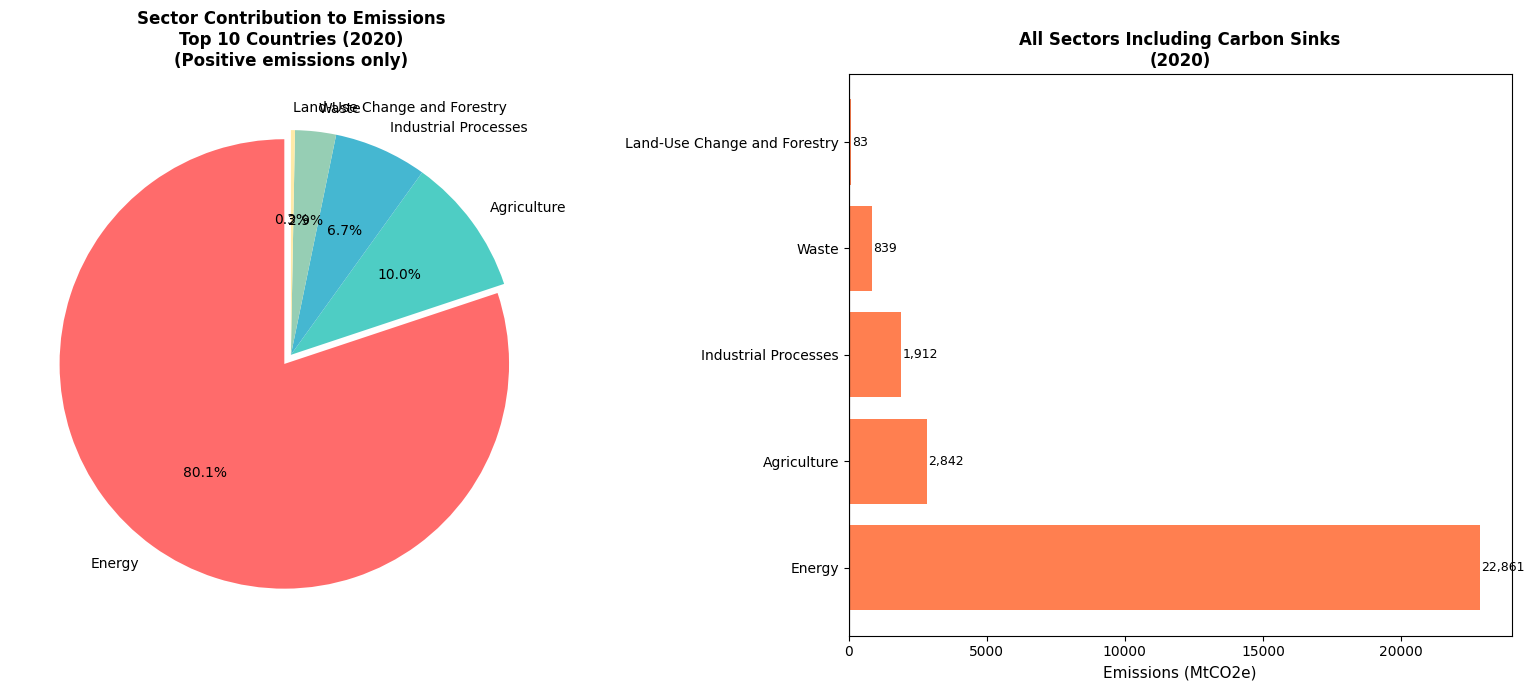


📊 Summary:
   Total Emissions (positive only): 28,536.32 MtCO2e
   Total Net Emissions (with sinks): 28,536.32 MtCO2e


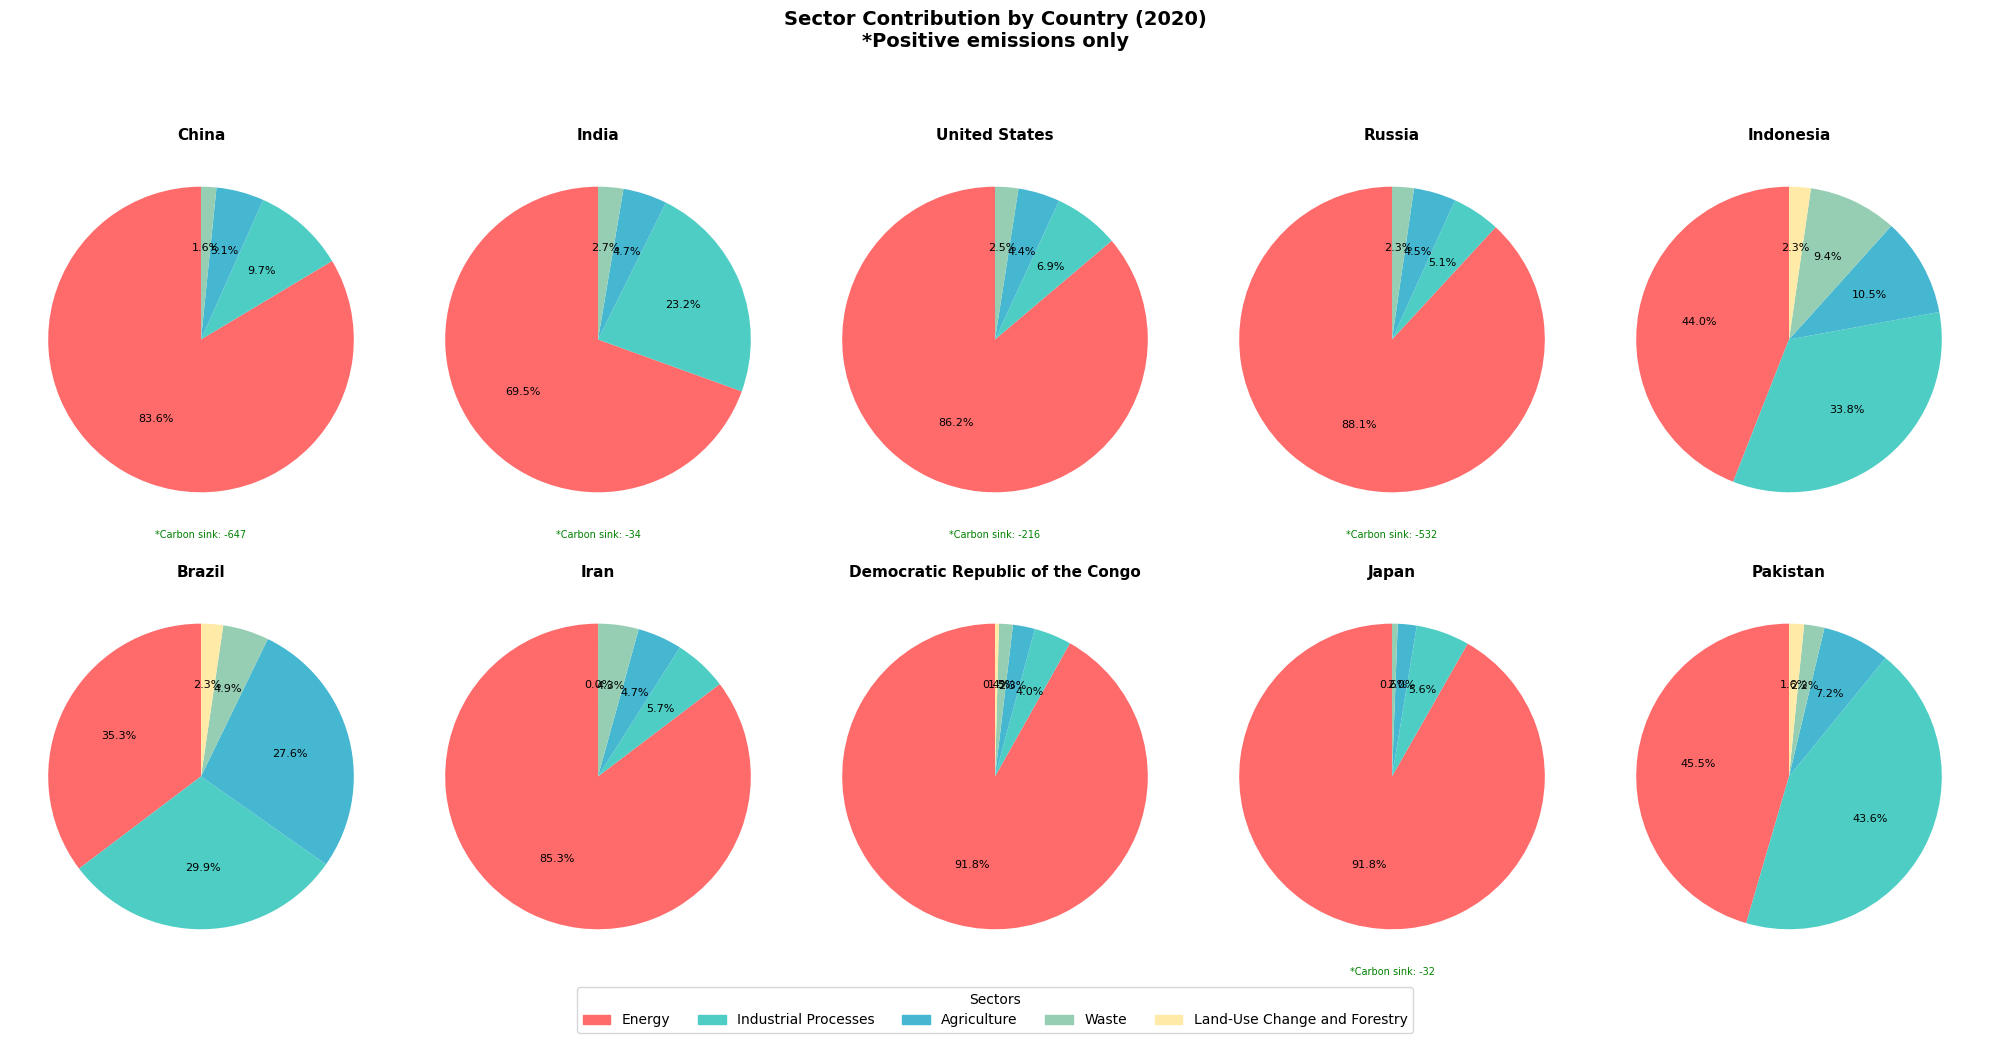

In [ ]:
# ============================================================================
# PIE CHARTS - FIXED FOR NEGATIVE VALUES (LUCF sector)
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np

# ============================================================================
# 1. OVERALL PIE CHART - Handle Negative Values
# ============================================================================

# Get sector totals for top 10 countries
top10_sector_data = sector_data[sector_data['ISO'].isin(TOP10_COUNTRIES)]
sector_totals = top10_sector_data.groupby('Sector')[latest_year].sum().sort_values(ascending=False)

# Check for negative values
print("Sector Totals (including negatives):")
print(sector_totals)
print(f"\nNegative sectors: {sector_totals[sector_totals < 0].index.tolist()}")

# OPTION 1: Exclude negative values from pie chart
sector_positive = sector_totals[sector_totals > 0]

# OPTION 2: Use absolute values (uncomment if preferred)
# sector_positive = sector_totals.abs()

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- Left: Pie chart (positive values only) ---
ax1 = axes[0]
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4', '#ffeaa7'][:len(sector_positive)]
explode = [0.05 if i == 0 else 0 for i in range(len(sector_positive))]

wedges, texts, autotexts = ax1.pie(
    sector_positive, 
    labels=sector_positive.index, 
    autopct='%1.1f%%',
    colors=colors, 
    explode=explode, 
    startangle=90,
    textprops={'fontsize': 10}
)

ax1.set_title(f'Sector Contribution to Emissions\nTop 10 Countries ({latest_year})\n(Positive emissions only)', 
             fontsize=12, fontweight='bold')

# --- Right: Bar chart (shows all including negative) ---
ax2 = axes[1]
colors_bar = ['green' if v < 0 else 'coral' for v in sector_totals.values]
bars = ax2.barh(sector_totals.index, sector_totals.values, color=colors_bar)
ax2.axvline(x=0, color='black', linewidth=0.8)
ax2.set_xlabel('Emissions (MtCO2e)', fontsize=11)
ax2.set_title(f'All Sectors Including Carbon Sinks\n({latest_year})', fontsize=12, fontweight='bold')

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax2.text(width + (50 if width >= 0 else -50), bar.get_y() + bar.get_height()/2,
             f'{width:,.0f}', ha='left' if width >= 0 else 'right', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('sector_pie_with_negatives.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print(f"\nSummary:")
print(f"   Total Emissions (positive only): {sector_positive.sum():,.2f} MtCO2e")
print(f"   Total Net Emissions (with sinks): {sector_totals.sum():,.2f} MtCO2e")
if (sector_totals < 0).any():
    print(f"   Carbon Sinks (negative): {sector_totals[sector_totals < 0].sum():,.2f} MtCO2e")

# ============================================================================
# 2. INDIVIDUAL COUNTRY PIE CHARTS - Handle Negatives
# ============================================================================

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

country_names = top10_sector_data.drop_duplicates('ISO').set_index('ISO')['Country'].to_dict()

for idx, country_iso in enumerate(TOP10_COUNTRIES):
    ax = axes[idx]
    
    # Get sector data for this country
    country_data = top10_sector_data[top10_sector_data['ISO'] == country_iso]
    country_sectors = country_data.groupby('Sector')[latest_year].sum()
    
    country_name = country_names.get(country_iso, country_iso)
    
    # Filter to positive values only for pie chart
    country_positive = country_sectors[country_sectors > 0].sort_values(ascending=False)
    
    if len(country_positive) == 0:
        ax.text(0.5, 0.5, 'No positive\nemissions', ha='center', va='center', fontsize=10)
        ax.set_title(f'{country_name}', fontsize=11, fontweight='bold')
        ax.axis('off')
        continue
    
    # Create pie chart
    wedges, texts, autotexts = ax.pie(
        country_positive, 
        autopct='%1.1f%%',
        colors=colors[:len(country_positive)],
        startangle=90,
        textprops={'fontsize': 8}
    )
    
    # Add note if LUCF is negative
    if (country_sectors < 0).any():
        negative_val = country_sectors[country_sectors < 0].sum()
        ax.text(0, -1.3, f'*Carbon sink: {negative_val:,.0f}', ha='center', fontsize=7, color='green')
    
    ax.set_title(f'{country_name}', fontsize=11, fontweight='bold')

# Add legend
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(MAIN_SECTORS))]
fig.legend(handles, MAIN_SECTORS, loc='center', bbox_to_anchor=(0.5, 0.02), 
           ncol=5, fontsize=10, title='Sectors')

plt.suptitle(f'Sector Contribution by Country ({latest_year})\n*Positive emissions only', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('sector_pie_by_country.png', dpi=300, bbox_inches='tight')
plt.show()